# RDS-02 Построение модели предсказания результатов госэкзамена по математике для учеников школы

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Импорт модулей и определение функций

In [1]:
# %load imports.py
#импорты
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind
import os
from collections import Counter

In [2]:
# %load tune.py
#настроить mathplotlib
%matplotlib inline
#настроим pandas
pd.set_option('display.max_rows', 200) # выведем больше строк
pd.set_option('display.max_columns', 80) # выведем больше колонок

In [3]:
from dsa import show_column_info, clear_num_col, get_boxplot, get_stat_diff, show_df_info

## Изучим датасет

In [4]:
#адреса, пароли, явки
fn_stud_math = 'stud_math.xls'
path = r""

#загрузить датасет
studs = pd.read_csv(os.path.join(path, fn_stud_math))

### Предварительный обзор датасета

Предварительные наблюдения по датасету:
1. В датасете 395 строк
1. В датасете есть столбец *"studytime, granular"*, которого нет в описании датасета
1. Большинство столбцов имеют незначительное количество уникальных значений
1. Почти все столбцы имеют мало пропусков (менее 10%), однако только четверть строк не имеют ни одного пропуска в столбцах


In [5]:
show_df_info(studs)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Количество строк в датасете: 395
Cтолбцы в датасете (30):


,column,not_null_unique_values_count,not_null_count,d_type,percent_not_null_value
0,school,2,395,object,1.000000
1,sex,2,395,object,1.000000
2,age,8,395,int64,1.000000
3,address,2,378,object,0.956962
4,famsize,2,368,object,0.931646
5,Pstatus,2,350,object,0.886076
6,Medu,5,392,float64,0.992405
7,Fedu,6,371,float64,0.939241
8,Mjob,5,376,object,0.951899
9,Fjob,5,359,object,0.908861


Типы столбцов:


d_type,int64,float64,object
column,1,12,17


In [6]:
show_df_info(studs.dropna())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
10,GP,F,15,U,GT3,T,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,3.0,2.0,0.0,45.0
14,GP,M,15,U,GT3,A,2.0,2.0,other,other,home,other,1.0,3.0,0.0,no,yes,no,no,yes,-9.0,yes,yes,yes,4.0,5.0,2.0,3.0,0.0,80.0


Количество строк в датасете: 97
Cтолбцы в датасете (30):


,column,not_null_unique_values_count,not_null_count,d_type,percent_not_null_value
0,school,2,97,object,1.0
1,sex,2,97,object,1.0
2,age,7,97,int64,1.0
3,address,2,97,object,1.0
4,famsize,2,97,object,1.0
5,Pstatus,2,97,object,1.0
6,Medu,5,97,float64,1.0
7,Fedu,4,97,float64,1.0
8,Mjob,5,97,object,1.0
9,Fjob,5,97,object,1.0


Типы столбцов:


d_type,int64,float64,object
column,1,12,17


### absences — количество пропущенных занятий

1. Содержит 12 пропущенных значений
1. Содержит потенциальные выбросы, которые можно попробовать почистить с помощью межквартильного интервала

Тип поля absences: float64
Количество непустых значений: 383
Количество уникальных непустых значений: 36


,absences,count,percent
0,0.0,111,0.281013
1,1.0,3,0.007595
2,2.0,60,0.151899
3,3.0,8,0.020253
4,4.0,53,0.134177
5,5.0,5,0.012658
6,6.0,31,0.078481
7,7.0,6,0.015190
8,8.0,21,0.053165
9,9.0,3,0.007595


count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

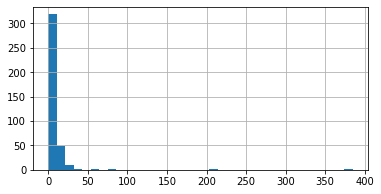

In [7]:
show_column_info(studs, 'absences', bins=36, fig_size_x=6, fig_size_y=3)

### activities — дополнительные внеучебные занятия (yes или no)
1. Not-null значения, соответствуют ожидаемым

Тип поля activities: object
Количество непустых значений: 381
Количество уникальных непустых значений: 2


,activities,count,percent
0,no,186,0.470886
1,yes,195,0.493671
2,NaN,14,0.035443


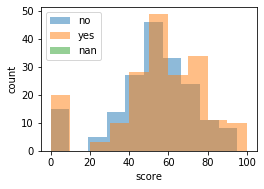

In [8]:
show_column_info(studs,'activities')

### address — тип адреса ученика ('U' - городской, 'R' - за городом)

1. Not-Null значения соответствуют ожидаемым

Тип поля address: object
Количество непустых значений: 378
Количество уникальных непустых значений: 2


,address,count,percent
0,R,83,0.210127
1,U,295,0.746835
2,NaN,17,0.043038


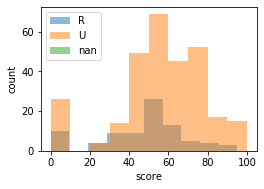

In [9]:
show_column_info(studs,'address')

### age — возраст ученика (от 15 до 22)

1. Значения столбца имеют примерно нормальное распределение

Тип поля age: int64
Количество непустых значений: 395
Количество уникальных непустых значений: 8


,age,count,percent
0,15,82,0.207595
1,16,104,0.263291
2,17,98,0.248101
3,18,82,0.207595
4,19,24,0.060759
5,20,3,0.007595
6,21,1,0.002532
7,22,1,0.002532


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

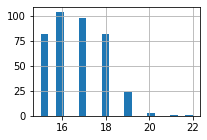

In [10]:
show_column_info(studs,'age')

### failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)

1. Большинство строк имеют значение 0, которое отсутствует в описании. Исходя из смысла столбца это, вероятно, ошибка описания. 
3. Значение "3" тоже отсутствует в описании - возможно это тоже ошибка описания.

Тип поля failures: float64
Количество непустых значений: 373
Количество уникальных непустых значений: 4


,failures,count,percent
0,0.0,293,0.741772
1,1.0,49,0.124051
2,2.0,16,0.040506
3,3.0,15,0.037975
4,NaN,22,0.055696


count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

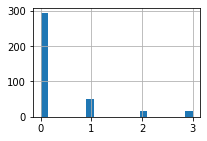

In [11]:
show_column_info(studs,'failures')

### famsize — размер семьи('LE3' <= 3, 'GT3' >3)
1. Not-Null значения соответствуют ожидаемым

Тип поля famsize: object
Количество непустых значений: 368
Количество уникальных непустых значений: 2


,famsize,count,percent
0,GT3,261,0.660759
1,LE3,107,0.270886
2,NaN,27,0.068354


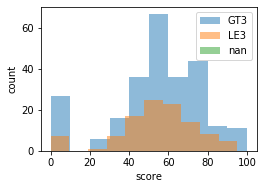

In [12]:
show_column_info(studs,'famsize')

### famsup — семейная образовательная поддержка (yes или no)
1. Not-Null значения соответствуют ожидаемым

Тип поля famsup: object
Количество непустых значений: 356
Количество уникальных непустых значений: 2


,famsup,count,percent
0,no,137,0.346835
1,yes,219,0.554430
2,NaN,39,0.098734


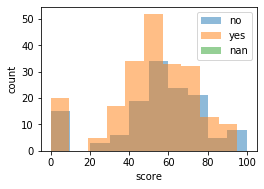

In [13]:
show_column_info(studs,'famsup')

### famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
1. В данных присутствует значение "-1.0", которое отсутствует в описании столбца. Имеет смысл вычистить эту строку.

Тип поля famrel: float64
Количество непустых значений: 368
Количество уникальных непустых значений: 6


,famrel,count,percent
0,-1.0,1,0.002532
1,1.0,7,0.017722
2,2.0,17,0.043038
3,3.0,62,0.156962
4,4.0,182,0.460759
5,5.0,99,0.250633
6,NaN,27,0.068354


count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

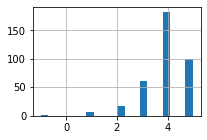

In [14]:
show_column_info(studs,'famrel')

### Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
1.Поле Fedu содержит явный выброс со значением 40, который имеет смысл почистить.

Тип поля Fedu: float64
Количество непустых значений: 371
Количество уникальных непустых значений: 6


,Fedu,count,percent
0,0.0,2,0.005063
1,1.0,78,0.197468
2,2.0,106,0.268354
3,3.0,96,0.243038
4,4.0,88,0.222785
5,40.0,1,0.002532
6,NaN,24,0.060759


count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

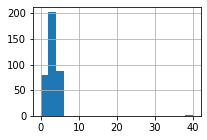

In [15]:
show_column_info(studs,'Fedu')

### Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

1. Not-Null имеют ожидаемые значения

Тип поля Fjob: object
Количество непустых значений: 359
Количество уникальных непустых значений: 5


,Fjob,count,percent
0,at_home,16,0.040506
1,health,15,0.037975
2,other,197,0.498734
3,services,102,0.258228
4,teacher,29,0.073418
5,NaN,36,0.091139


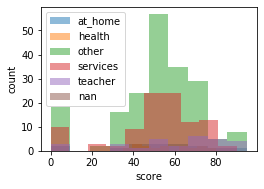

In [16]:
show_column_info(studs,'Fjob')

### freetime  — свободное время после школы (от 1 - очень мало до 5 - очень мого)

1. Not-Null имеют ожидаемые значения

Тип поля freetime: float64
Количество непустых значений: 384
Количество уникальных непустых значений: 5


,freetime,count,percent
0,1.0,18,0.045570
1,2.0,63,0.159494
2,3.0,153,0.387342
3,4.0,112,0.283544
4,5.0,38,0.096203
5,NaN,11,0.027848


count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

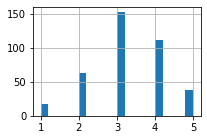

In [17]:
show_column_info(studs,'freetime')

### goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
1. Not-Null имеют ожидаемые значения

Тип поля goout: float64
Количество непустых значений: 387
Количество уникальных непустых значений: 5


,goout,count,percent
0,1.0,23,0.058228
1,2.0,101,0.255696
2,3.0,127,0.321519
3,4.0,84,0.212658
4,5.0,52,0.131646
5,NaN,8,0.020253


count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

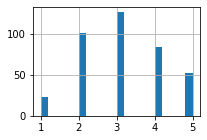

In [18]:
show_column_info(studs,'goout')

### guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
1. Not-Null имеют ожидаемые значения

Тип поля guardian: object
Количество непустых значений: 364
Количество уникальных непустых значений: 3


,guardian,count,percent
0,father,86,0.217722
1,mother,250,0.632911
2,other,28,0.070886
3,NaN,31,0.078481


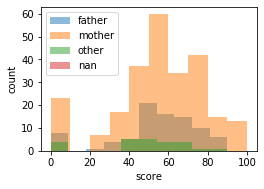

In [19]:
show_column_info(studs,'guardian')

### health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
1. Not-Null имеют ожидаемые значения

Тип поля health: float64
Количество непустых значений: 380
Количество уникальных непустых значений: 5


,health,count,percent
0,1.0,47,0.118987
1,2.0,43,0.108861
2,3.0,89,0.225316
3,4.0,63,0.159494
4,5.0,138,0.349367
5,NaN,15,0.037975


count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

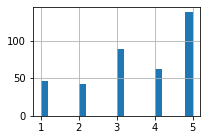

In [20]:
show_column_info(studs,'health')

### higher — хочет получить высшее образование (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля higher: object
Количество непустых значений: 375
Количество уникальных непустых значений: 2


,higher,count,percent
0,no,19,0.048101
1,yes,356,0.901266
2,NaN,20,0.050633


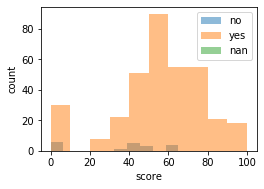

In [21]:
show_column_info(studs,'higher')

### internet — наличие интернета дома (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля internet: object
Количество непустых значений: 361
Количество уникальных непустых значений: 2


,internet,count,percent
0,no,56,0.141772
1,yes,305,0.772152
2,NaN,34,0.086076


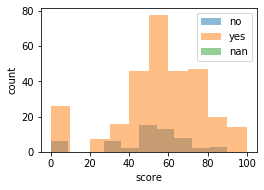

In [22]:
show_column_info(studs,'internet')

### Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
1. Not-Null имеют ожидаемые значения

Тип поля Medu: float64
Количество непустых значений: 392
Количество уникальных непустых значений: 5


,Medu,count,percent
0,0.0,3,0.007595
1,1.0,59,0.149367
2,2.0,102,0.258228
3,3.0,97,0.245570
4,4.0,131,0.331646
5,NaN,3,0.007595


count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

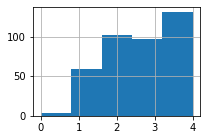

In [23]:
show_column_info(studs,'Medu', bins=5)

### Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
1. Not-Null имеют ожидаемые значения

Тип поля Mjob: object
Количество непустых значений: 376
Количество уникальных непустых значений: 5


,Mjob,count,percent
0,at_home,58,0.146835
1,health,32,0.081013
2,other,133,0.336709
3,services,98,0.248101
4,teacher,55,0.139241
5,NaN,19,0.048101


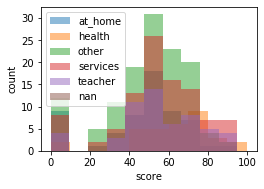

In [24]:
show_column_info(studs,'Mjob')

### nursery — посещал детский сад (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля nursery: object
Количество непустых значений: 379
Количество уникальных непустых значений: 2


,nursery,count,percent
0,no,79,0.200000
1,yes,300,0.759494
2,NaN,16,0.040506


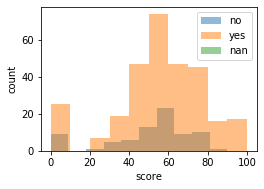

In [25]:
show_column_info(studs,'nursery')

### paid — дополнительные платные занятия по математике (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля paid: object
Количество непустых значений: 355
Количество уникальных непустых значений: 2


,paid,count,percent
0,no,200,0.506329
1,yes,155,0.392405
2,NaN,40,0.101266


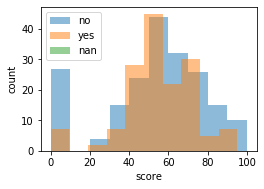

In [26]:
show_column_info(studs,'paid')

### Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
1. Not-Null имеют ожидаемые значения

Тип поля Pstatus: object
Количество непустых значений: 350
Количество уникальных непустых значений: 2


,Pstatus,count,percent
0,A,36,0.091139
1,T,314,0.794937
2,NaN,45,0.113924


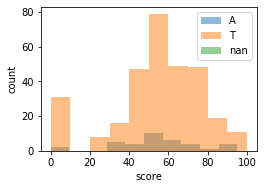

In [27]:
show_column_info(studs,'Pstatus')

### reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
1. Not-Null имеют ожидаемые значения

Тип поля reason: object
Количество непустых значений: 378
Количество уникальных непустых значений: 4


,reason,count,percent
0,course,137,0.346835
1,home,104,0.263291
2,other,34,0.086076
3,reputation,103,0.260759
4,NaN,17,0.043038


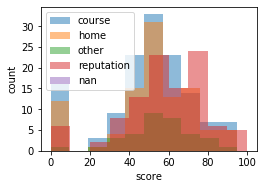

In [28]:
show_column_info(studs,'reason')

### romantic — в романтических отношениях (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля romantic: object
Количество непустых значений: 364
Количество уникальных непустых значений: 2


,romantic,count,percent
0,no,240,0.607595
1,yes,124,0.313924
2,NaN,31,0.078481


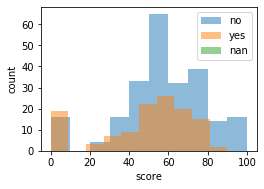

In [29]:
show_column_info(studs,'romantic')

### school  — аббревиатура школы, в которой учится ученик
1. Датасет содержит данные по ученикам двух школ с аббревиатурами *GP* и *MS*

Тип поля school: object
Количество непустых значений: 395
Количество уникальных непустых значений: 2


,school,count,percent
0,GP,349,0.883544
1,MS,46,0.116456


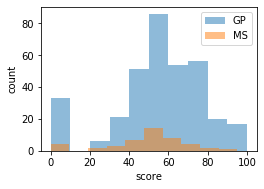

In [30]:
show_column_info(studs,'school')

### schoolsup — дополнительная образовательная поддержка (yes или no)
1. Not-Null имеют ожидаемые значения

Тип поля schoolsup: object
Количество непустых значений: 386
Количество уникальных непустых значений: 2


,schoolsup,count,percent
0,no,335,0.848101
1,yes,51,0.129114
2,NaN,9,0.022785


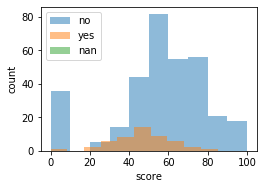

In [31]:
show_column_info(studs,'schoolsup')

### sex — пол ученика ('F' - женский, 'M' - мужской)
1. Not-Null имеют ожидаемые значения

Тип поля sex: object
Количество непустых значений: 395
Количество уникальных непустых значений: 2


,sex,count,percent
0,F,208,0.526582
1,M,187,0.473418


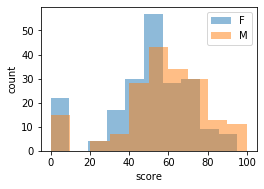

In [32]:
show_column_info(studs,'sex')

### score — баллы по госэкзамену по математике
1. Содержит значения в диапазоне от 0 до 100, что, вроде как, соответствует предметной области
1. Содержит 6 строк с пропущенными значениями, которые имеет смысл почистить

Тип поля score: float64
Количество непустых значений: 389
Количество уникальных непустых значений: 18


,score,count,percent
0,0.0,37,0.093671
1,20.0,1,0.002532
2,25.0,7,0.017722
3,30.0,15,0.037975
4,35.0,9,0.022785
5,40.0,31,0.078481
6,45.0,27,0.068354
7,50.0,54,0.136709
8,55.0,46,0.116456
9,60.0,31,0.078481


count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

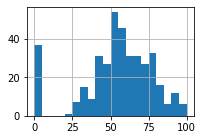

In [33]:
show_column_info(studs,'score', bins=20)

### studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
1. Not-Null имеют ожидаемые значения

Тип поля studytime: float64
Количество непустых значений: 388
Количество уникальных непустых значений: 4


,studytime,count,percent
0,1.0,103,0.260759
1,2.0,194,0.491139
2,3.0,64,0.162025
3,4.0,27,0.068354
4,NaN,7,0.017722


count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

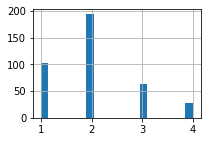

In [34]:
show_column_info(studs,'studytime')

### studytime, granular
1. Столбец отсутствует в описании набора данных

Тип поля studytime, granular: float64
Количество непустых значений: 388
Количество уникальных непустых значений: 4


,"studytime, granular",count,percent
0,-12.0,27,0.068354
1,-9.0,64,0.162025
2,-6.0,194,0.491139
3,-3.0,103,0.260759
4,NaN,7,0.017722


count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

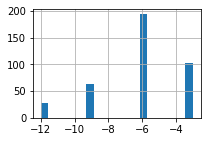

In [35]:
show_column_info(studs,'studytime, granular')

### traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
1. Not-Null имеют ожидаемые значения

Тип поля traveltime: float64
Количество непустых значений: 367
Количество уникальных непустых значений: 4


,traveltime,count,percent
0,1.0,242,0.612658
1,2.0,96,0.243038
2,3.0,22,0.055696
3,4.0,7,0.017722
4,NaN,28,0.070886


count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

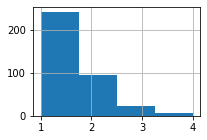

In [36]:
show_column_info(studs,'traveltime', bins=4)

Столбец *traveltime*:
1. Содержит 28 (7%) пропусков
2. Not-Null имеют ожидаемые значения

## Чистка данных

### Почистить поле Fedu

Тип поля Fedu: float64
Количество непустых значений: 370
Количество уникальных непустых значений: 5


,Fedu,count,percent
0,0.0,2,0.005076
1,1.0,78,0.197970
2,2.0,106,0.269036
3,3.0,96,0.243655
4,4.0,88,0.223350
5,NaN,24,0.060914


count    370.000000
mean       2.513514
std        1.087540
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

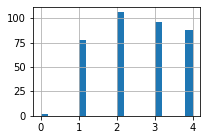

In [37]:
# Убрать строки с неправильными значениями Fedu
studs = clear_num_col(studs, 'Fedu', 0, 4)
show_column_info(studs,'Fedu')

### Почистить поле famrel

Тип поля famrel: float64
Количество непустых значений: 366
Количество уникальных непустых значений: 5


,famrel,count,percent
0,1.0,7,0.017812
1,2.0,17,0.043257
2,3.0,62,0.157761
3,4.0,182,0.463104
4,5.0,98,0.249364
5,NaN,27,0.068702


count    366.000000
mean       3.948087
std        0.891380
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

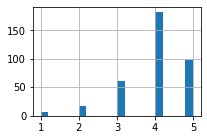

In [38]:
# Убрать строки с неправильными значениями famrel
studs = clear_num_col(studs, 'famrel', 1, 5)
show_column_info(studs,'famrel')

### Почистить поле absences

1. После удаления выбросов стало заметно "пилообразное" распределение значений столбца - основная масса строк имеет четные значения.

In [39]:
# Вычислить межквартильный интервал и границы допустимых значений
median = studs.absences.median()
IQR = studs.absences.quantile(0.75) - studs.absences.quantile(0.25)
low_limit = median - 1.5*IQR
high_limit = median + 1.5*IQR
print(f"Медиана: {median}")
print(f"Межквартильный интервал: {IQR}")
print(f"Нижняя граница допустимых значений: {low_limit} Верхняя граница допустимых значений: {high_limit}")
# Почистить значения
studs = clear_num_col(studs, 'absences', low_limit, high_limit)

Медиана: 4.0
Межквартильный интервал: 8.0
Нижняя граница допустимых значений: -8.0 Верхняя граница допустимых значений: 16.0


Тип поля absences: float64
Количество непустых значений: 353
Количество уникальных непустых значений: 17


,absences,count,percent
0,0.0,111,0.304110
1,1.0,3,0.008219
2,2.0,60,0.164384
3,3.0,8,0.021918
4,4.0,52,0.142466
5,5.0,5,0.013699
6,6.0,31,0.084932
7,7.0,6,0.016438
8,8.0,21,0.057534
9,9.0,3,0.008219


count    353.000000
mean       4.138810
std        4.339367
min        0.000000
25%        0.000000
50%        3.000000
75%        6.000000
max       16.000000
Name: absences, dtype: float64

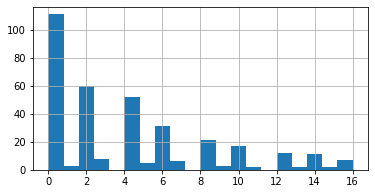

In [40]:
show_column_info(studs,'absences', bins=20, fig_size_x=6, fig_size_y=3)

### Почистить поле score

Тип поля score: float64
Количество непустых значений: 359
Количество уникальных непустых значений: 17


,score,count,percent
0,0.0,37,0.103064
1,25.0,7,0.019499
2,30.0,12,0.033426
3,35.0,8,0.022284
4,40.0,26,0.072423
5,45.0,23,0.064067
6,50.0,51,0.142061
7,55.0,42,0.116992
8,60.0,29,0.080780
9,65.0,27,0.075209


count    359.000000
mean      52.339833
std       23.355675
min        0.000000
25%       42.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

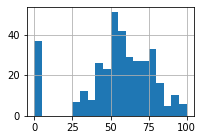

In [41]:
# Убрать строки с пустыми значениями поля score
studs = clear_num_col(studs, 'score', 0, 100, include_nan = False)

show_column_info(studs,'score', bins=20)

### Обзор датасета после чистки данных

1. В датасете осталосьб 359 строк из 395 строк (примерно 90%), что говорит о достаточно качественном наборе данных. 

In [42]:
show_df_info(studs)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Количество строк в датасете: 359
Cтолбцы в датасете (30):


,column,not_null_unique_values_count,not_null_count,d_type,percent_not_null_value
0,school,2,359,object,1.000000
1,sex,2,359,object,1.000000
2,age,8,359,int64,1.000000
3,address,2,344,object,0.958217
4,famsize,2,335,object,0.933148
5,Pstatus,2,322,object,0.896936
6,Medu,5,356,float64,0.991643
7,Fedu,5,337,float64,0.938719
8,Mjob,5,342,object,0.952646
9,Fjob,5,326,object,0.908078


Типы столбцов:


d_type,int64,float64,object
column,1,12,17


## Анализ данных

### Корреляция числовых данных
1. "studytime" и "studytime, granular" - сильно кореллируют друг с другом. "studytime, granular" можно исключить из модели данных
1. Также заметна сильная корреляция между переменными Medu и Fedu. Вероятно можно в моделе данных можно оставить только одну, например Medu.

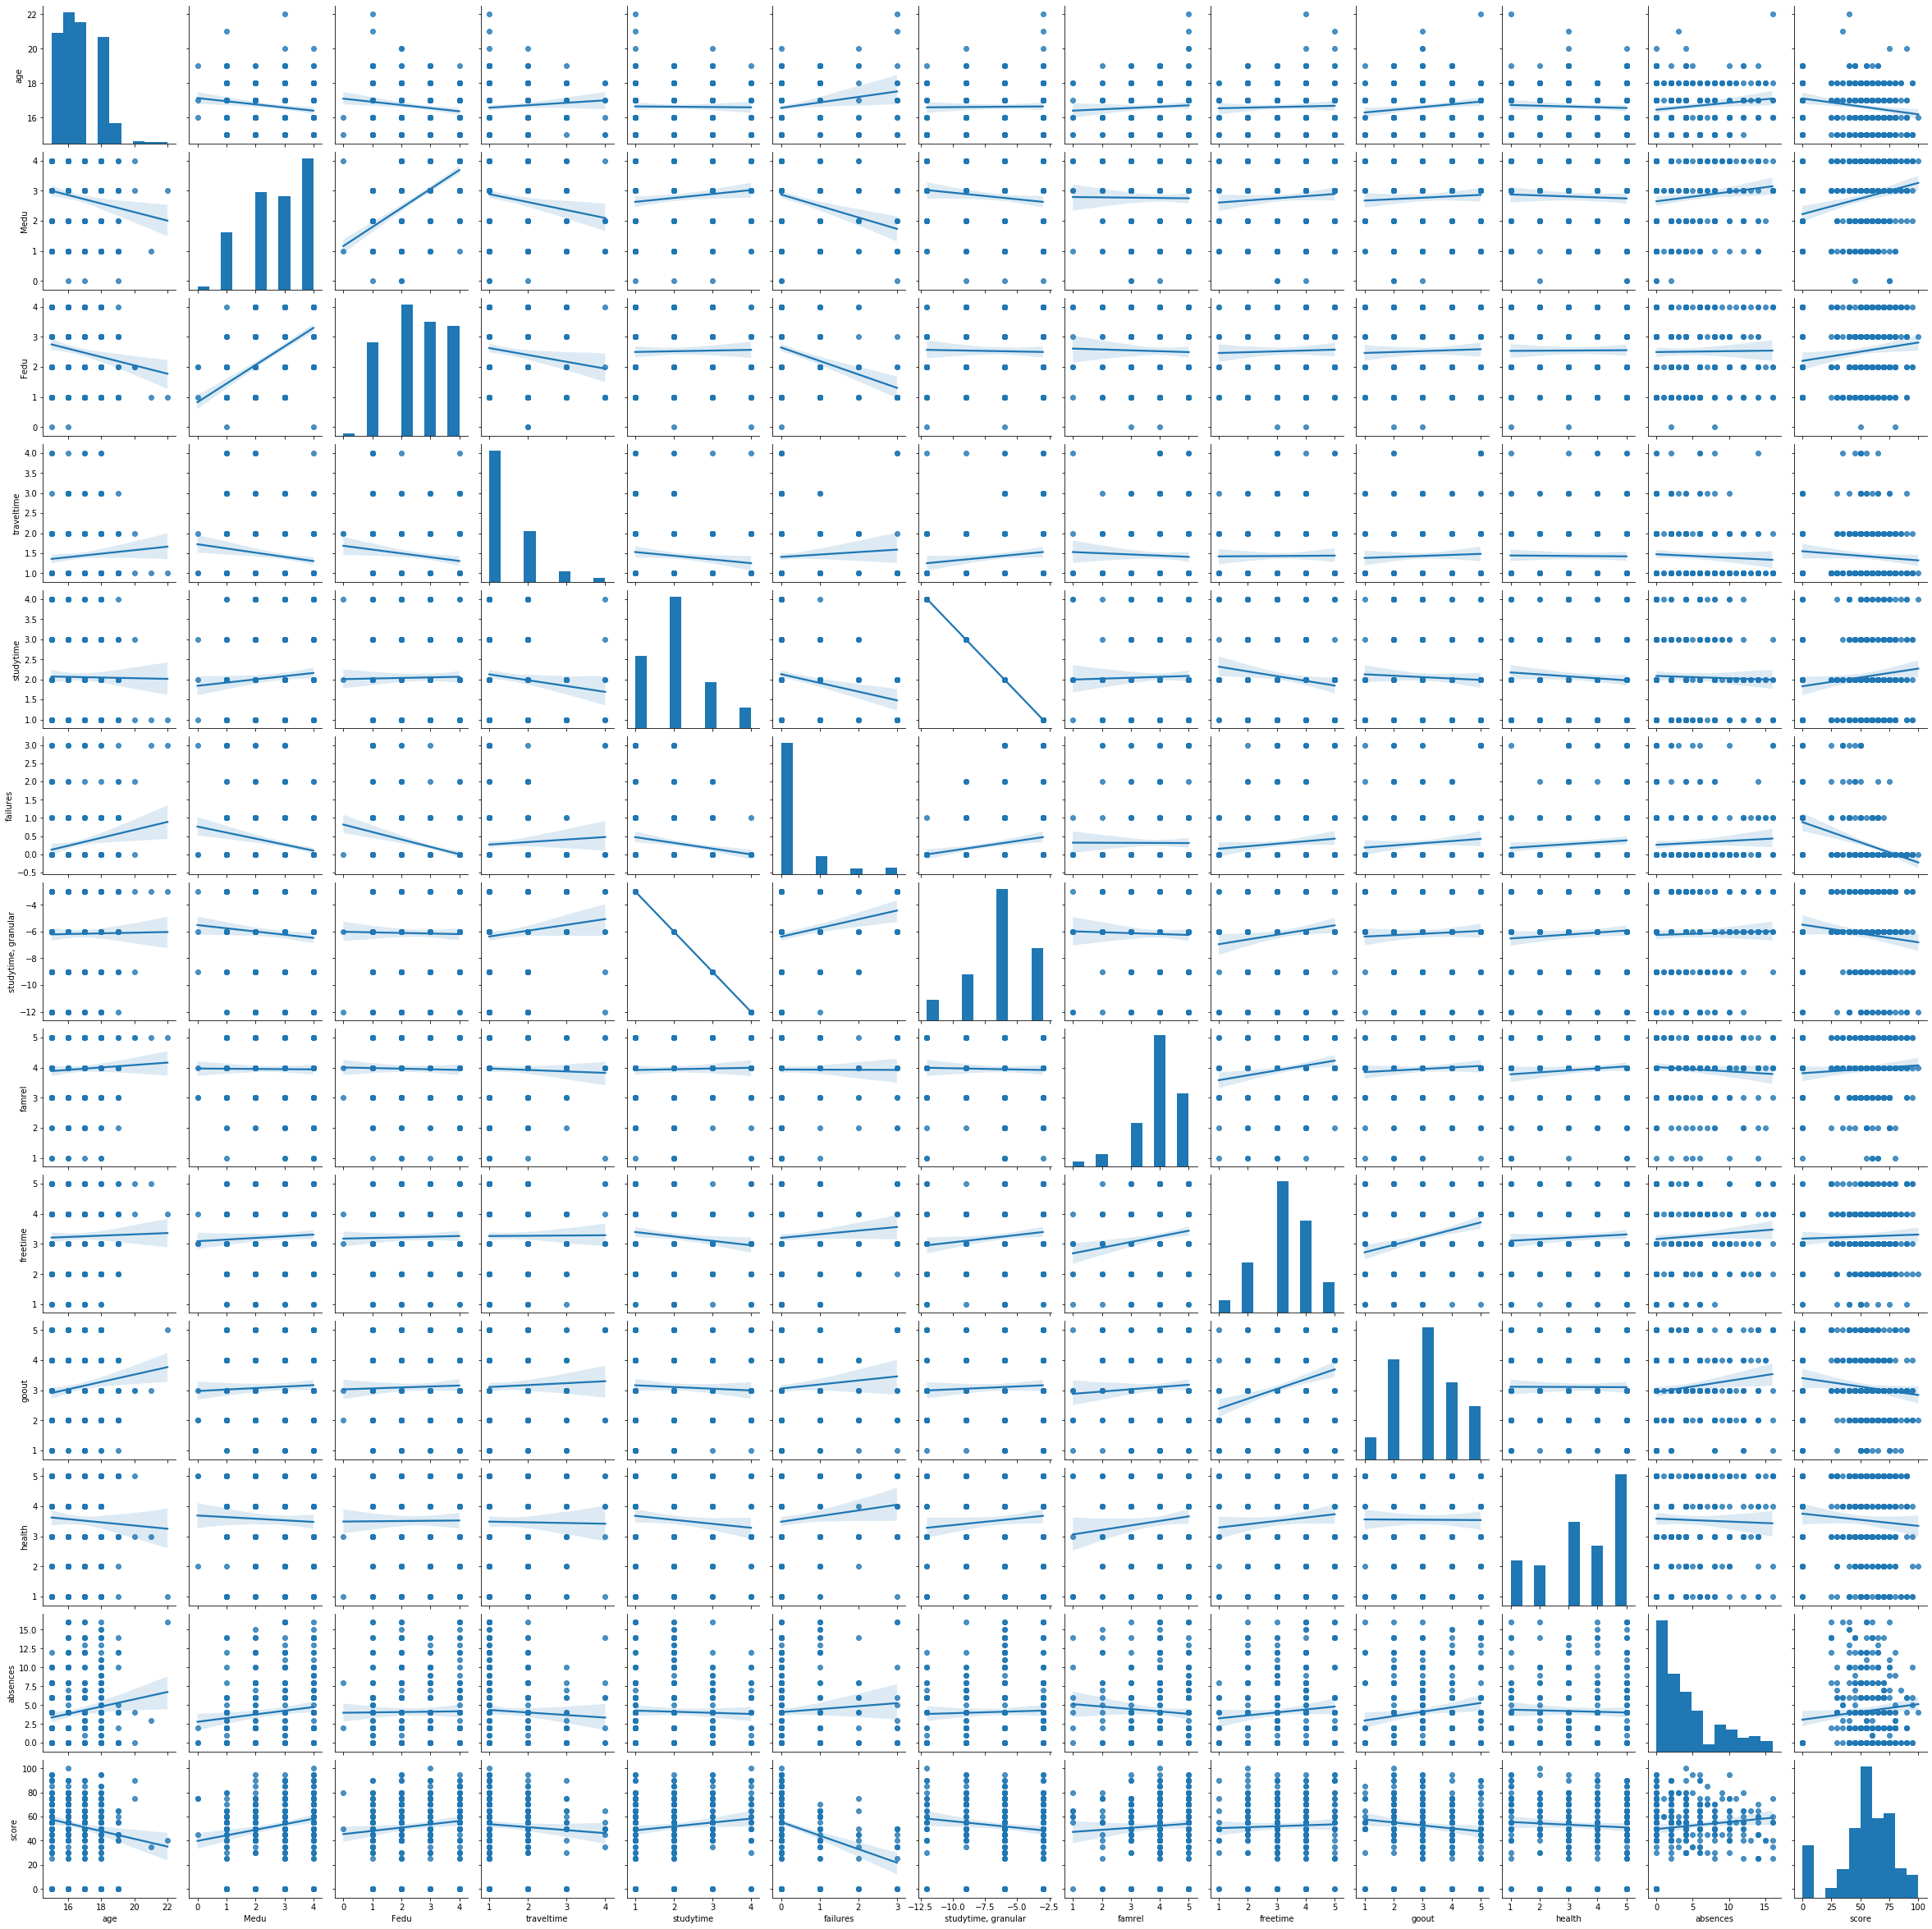

In [43]:
sns.pairplot(studs, kind = 'reg')

In [44]:
studs.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.161016,-0.159951,0.078751,-0.012158,0.186248,0.012158,0.055733,0.027746,0.139188,-0.048087,0.139740,-0.171746
Medu,-0.161016,1.000000,0.623390,-0.166397,0.102167,-0.250410,-0.102167,-0.008737,0.062450,0.048024,-0.041884,0.123353,0.218415
Fedu,-0.159951,0.623390,1.000000,-0.146647,0.018379,-0.301685,-0.018379,-0.024409,0.024664,0.031488,0.006746,0.011882,0.128829
traveltime,0.078751,-0.166397,-0.146647,1.000000,-0.115907,0.064941,0.115907,-0.038292,0.006361,0.040329,-0.011341,-0.054554,-0.075159
studytime,-0.012158,0.102167,0.018379,-0.115907,1.000000,-0.185041,-1.000000,0.023563,-0.131239,-0.044747,-0.080740,-0.029761,0.119262
failures,0.186248,-0.250410,-0.301685,0.064941,-0.185041,1.000000,0.185041,-0.003508,0.091166,0.089345,0.098022,0.065351,-0.352924
"studytime, granular",0.012158,-0.102167,-0.018379,0.115907,-1.000000,0.185041,1.000000,-0.023563,0.131239,0.044747,0.080740,0.029761,-0.119262
famrel,0.055733,-0.008737,-0.024409,-0.038292,0.023563,-0.003508,-0.023563,1.000000,0.174717,0.061751,0.099257,-0.068348,0.066743
freetime,0.027746,0.062450,0.024664,0.006361,-0.131239,0.091166,0.131239,0.174717,1.000000,0.284135,0.075823,0.087520,0.033204
goout,0.139188,0.048024,0.031488,0.040329,-0.044747,0.089345,0.044747,0.061751,0.284135,1.000000,-0.004346,0.147428,-0.117381


In [45]:
studs.corr()['score'].sort_values()

failures              -0.352924
age                   -0.171746
studytime, granular   -0.119262
goout                 -0.117381
traveltime            -0.075159
health                -0.067845
freetime               0.033204
famrel                 0.066743
absences               0.110058
studytime              0.119262
Fedu                   0.128829
Medu                   0.218415
score                  1.000000
Name: score, dtype: float64

### Анализ номинативных переменных
1. При уровне доверия 90% найдены статистически значимые различия для следующих столбцов:
  * sex
  * address
  * Mjob
  * schoolsup
  * paid
  * higher
  * romantic

Эти столбцы имеет смысл включить в модель данных для следующего анализа

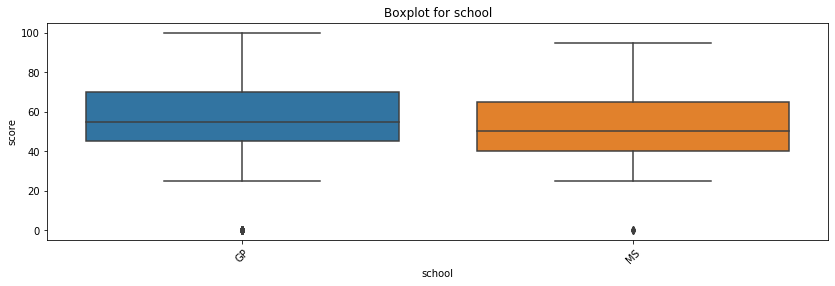

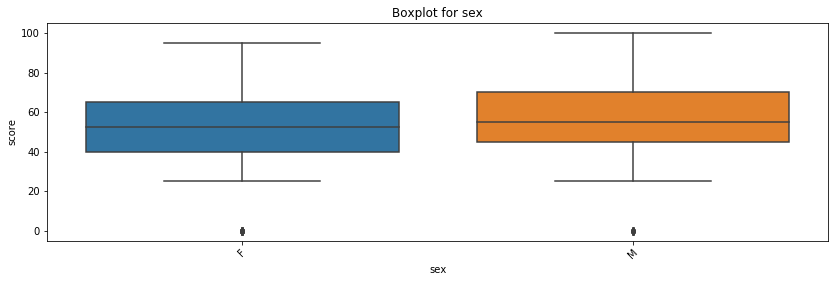

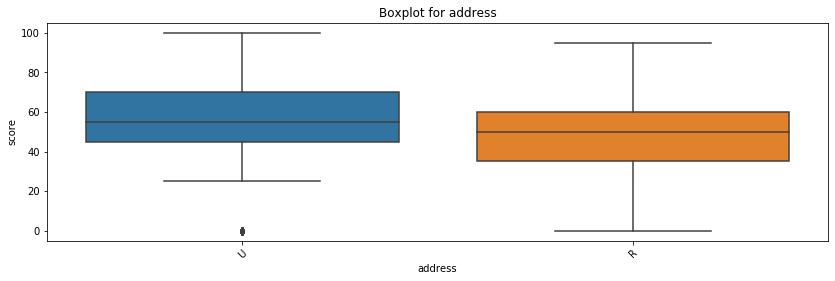

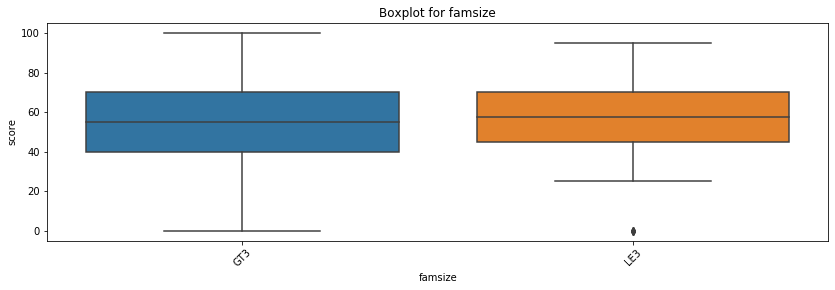

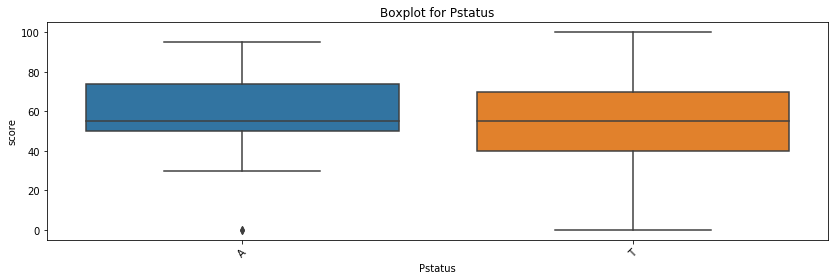

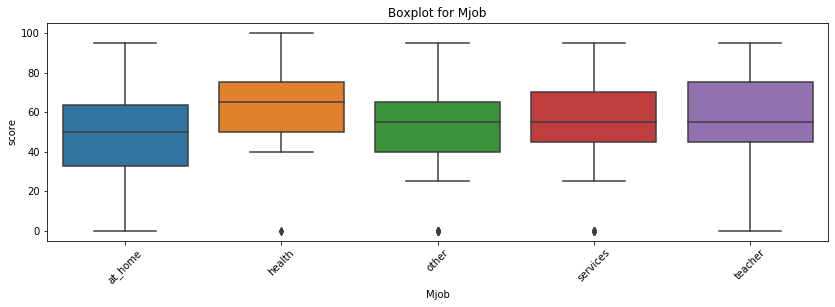

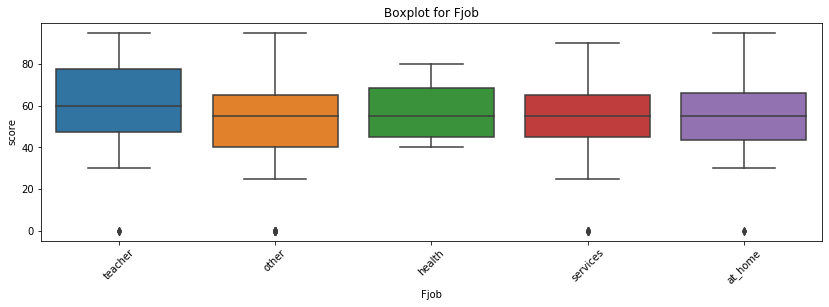

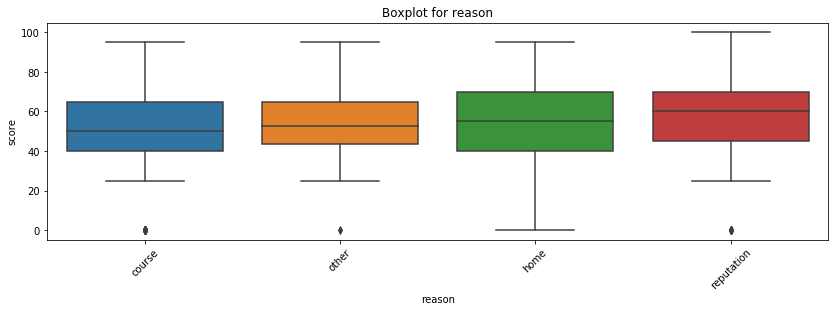

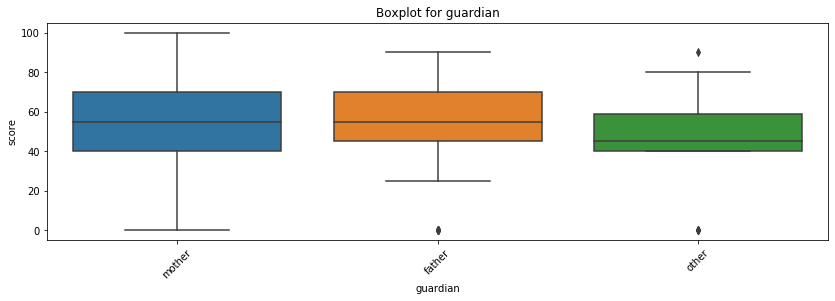

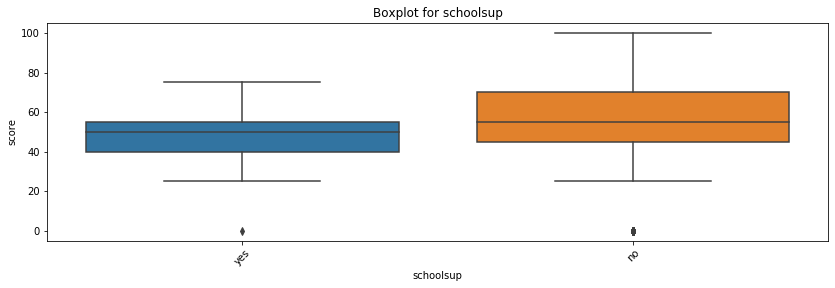

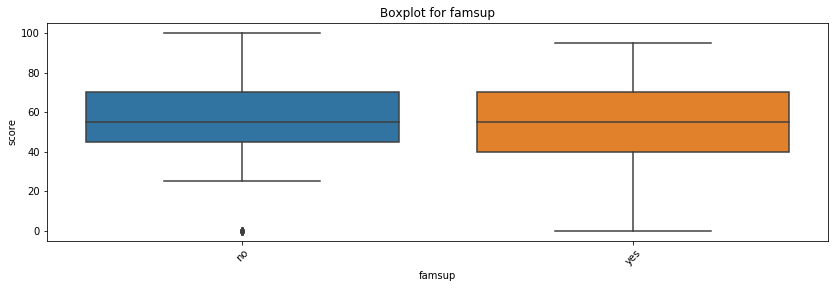

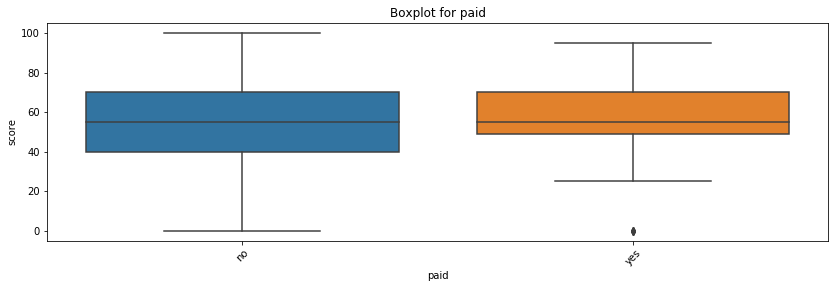

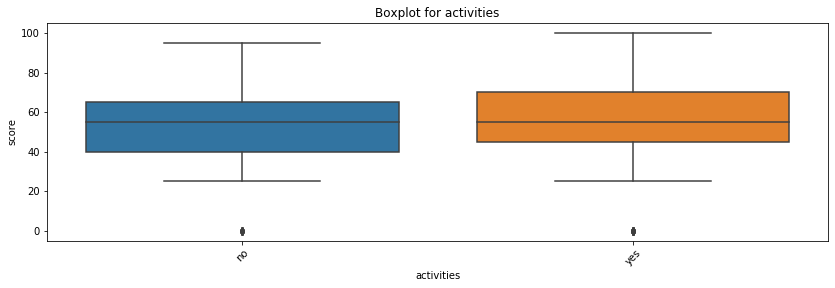

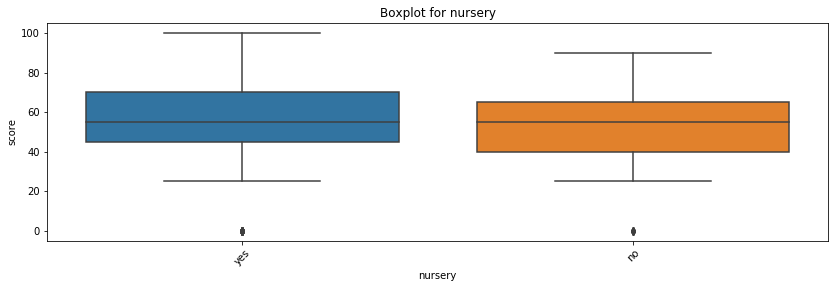

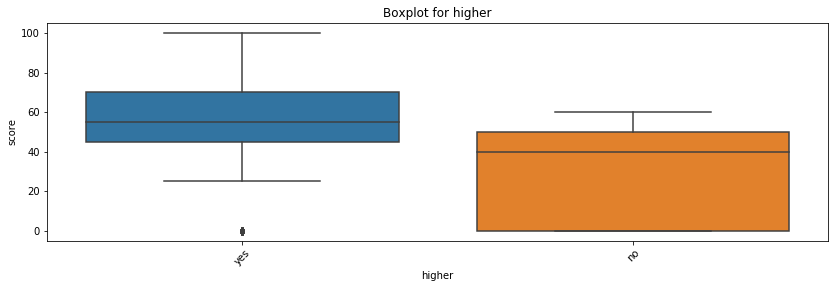

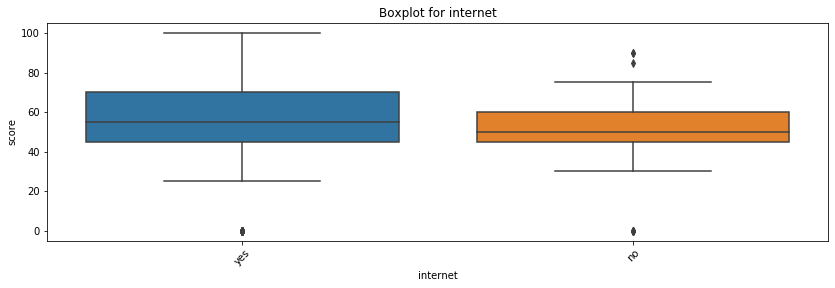

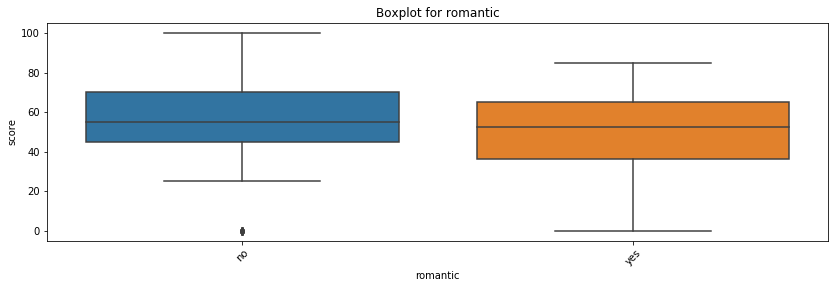

In [46]:
for col in (c for c in studs.columns if studs[c].dtype=='object'):
    get_boxplot(studs, col, 'score')

In [47]:
for col in (c for c in studs.columns if studs[c].dtype=='object'):
    get_stat_diff(studs, col, 'score', alpha=0.05)
print()
for col in (c for c in studs.columns if studs[c].dtype=='object'):
    get_stat_diff(studs, col, 'score', alpha=0.1)    

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


### Модель данных для дальнейшего анализа

In [48]:
studs_model = studs.loc[:, ['absences', 'age', 'failures', 'famrel', 'freetime', 'goout', 'health',
                            'Medu', 'studytime', 'traveltime', 
                            'sex', 'address', 'Mjob', 'schoolsup', 'paid', 'higher', 'romantic', 
                            'score']]

In [49]:
studs_model.head(10)

,absences,age,failures,famrel,freetime,goout,health,Medu,studytime,traveltime,sex,address,Mjob,schoolsup,paid,higher,romantic,score
0,6.0,18,0.0,4.0,3.0,4.0,3.0,4.0,2.0,2.0,F,U,at_home,yes,no,yes,no,30.0
1,4.0,17,0.0,5.0,3.0,3.0,3.0,1.0,2.0,1.0,F,U,at_home,no,no,yes,no,30.0
2,10.0,15,3.0,4.0,3.0,2.0,3.0,1.0,2.0,1.0,F,U,at_home,yes,NaN,yes,NaN,50.0
3,2.0,15,0.0,3.0,2.0,2.0,5.0,4.0,3.0,1.0,F,U,health,no,yes,yes,yes,75.0
4,4.0,16,0.0,4.0,3.0,2.0,5.0,3.0,2.0,1.0,F,U,other,no,yes,yes,no,50.0
5,10.0,16,0.0,5.0,4.0,2.0,5.0,4.0,2.0,1.0,M,U,services,no,yes,yes,no,75.0
6,0.0,16,0.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,M,NaN,other,no,no,yes,no,55.0
7,6.0,17,0.0,4.0,1.0,4.0,1.0,4.0,2.0,2.0,F,U,other,yes,no,yes,no,30.0
8,0.0,15,0.0,NaN,2.0,2.0,1.0,3.0,2.0,1.0,M,U,services,no,yes,yes,no,95.0
9,0.0,15,0.0,5.0,5.0,1.0,5.0,3.0,2.0,1.0,M,U,other,no,yes,yes,no,75.0


In [50]:
studs_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 0 to 394
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   absences    348 non-null    float64
 1   age         359 non-null    int64  
 2   failures    340 non-null    float64
 3   famrel      335 non-null    float64
 4   freetime    353 non-null    float64
 5   goout       353 non-null    float64
 6   health      344 non-null    float64
 7   Medu        356 non-null    float64
 8   studytime   352 non-null    float64
 9   traveltime  332 non-null    float64
 10  sex         359 non-null    object 
 11  address     344 non-null    object 
 12  Mjob        342 non-null    object 
 13  schoolsup   350 non-null    object 
 14  paid        322 non-null    object 
 15  higher      341 non-null    object 
 16  romantic    329 non-null    object 
 17  score       359 non-null    float64
dtypes: float64(10), int64(1), object(7)
memory usage: 63.3+ KB


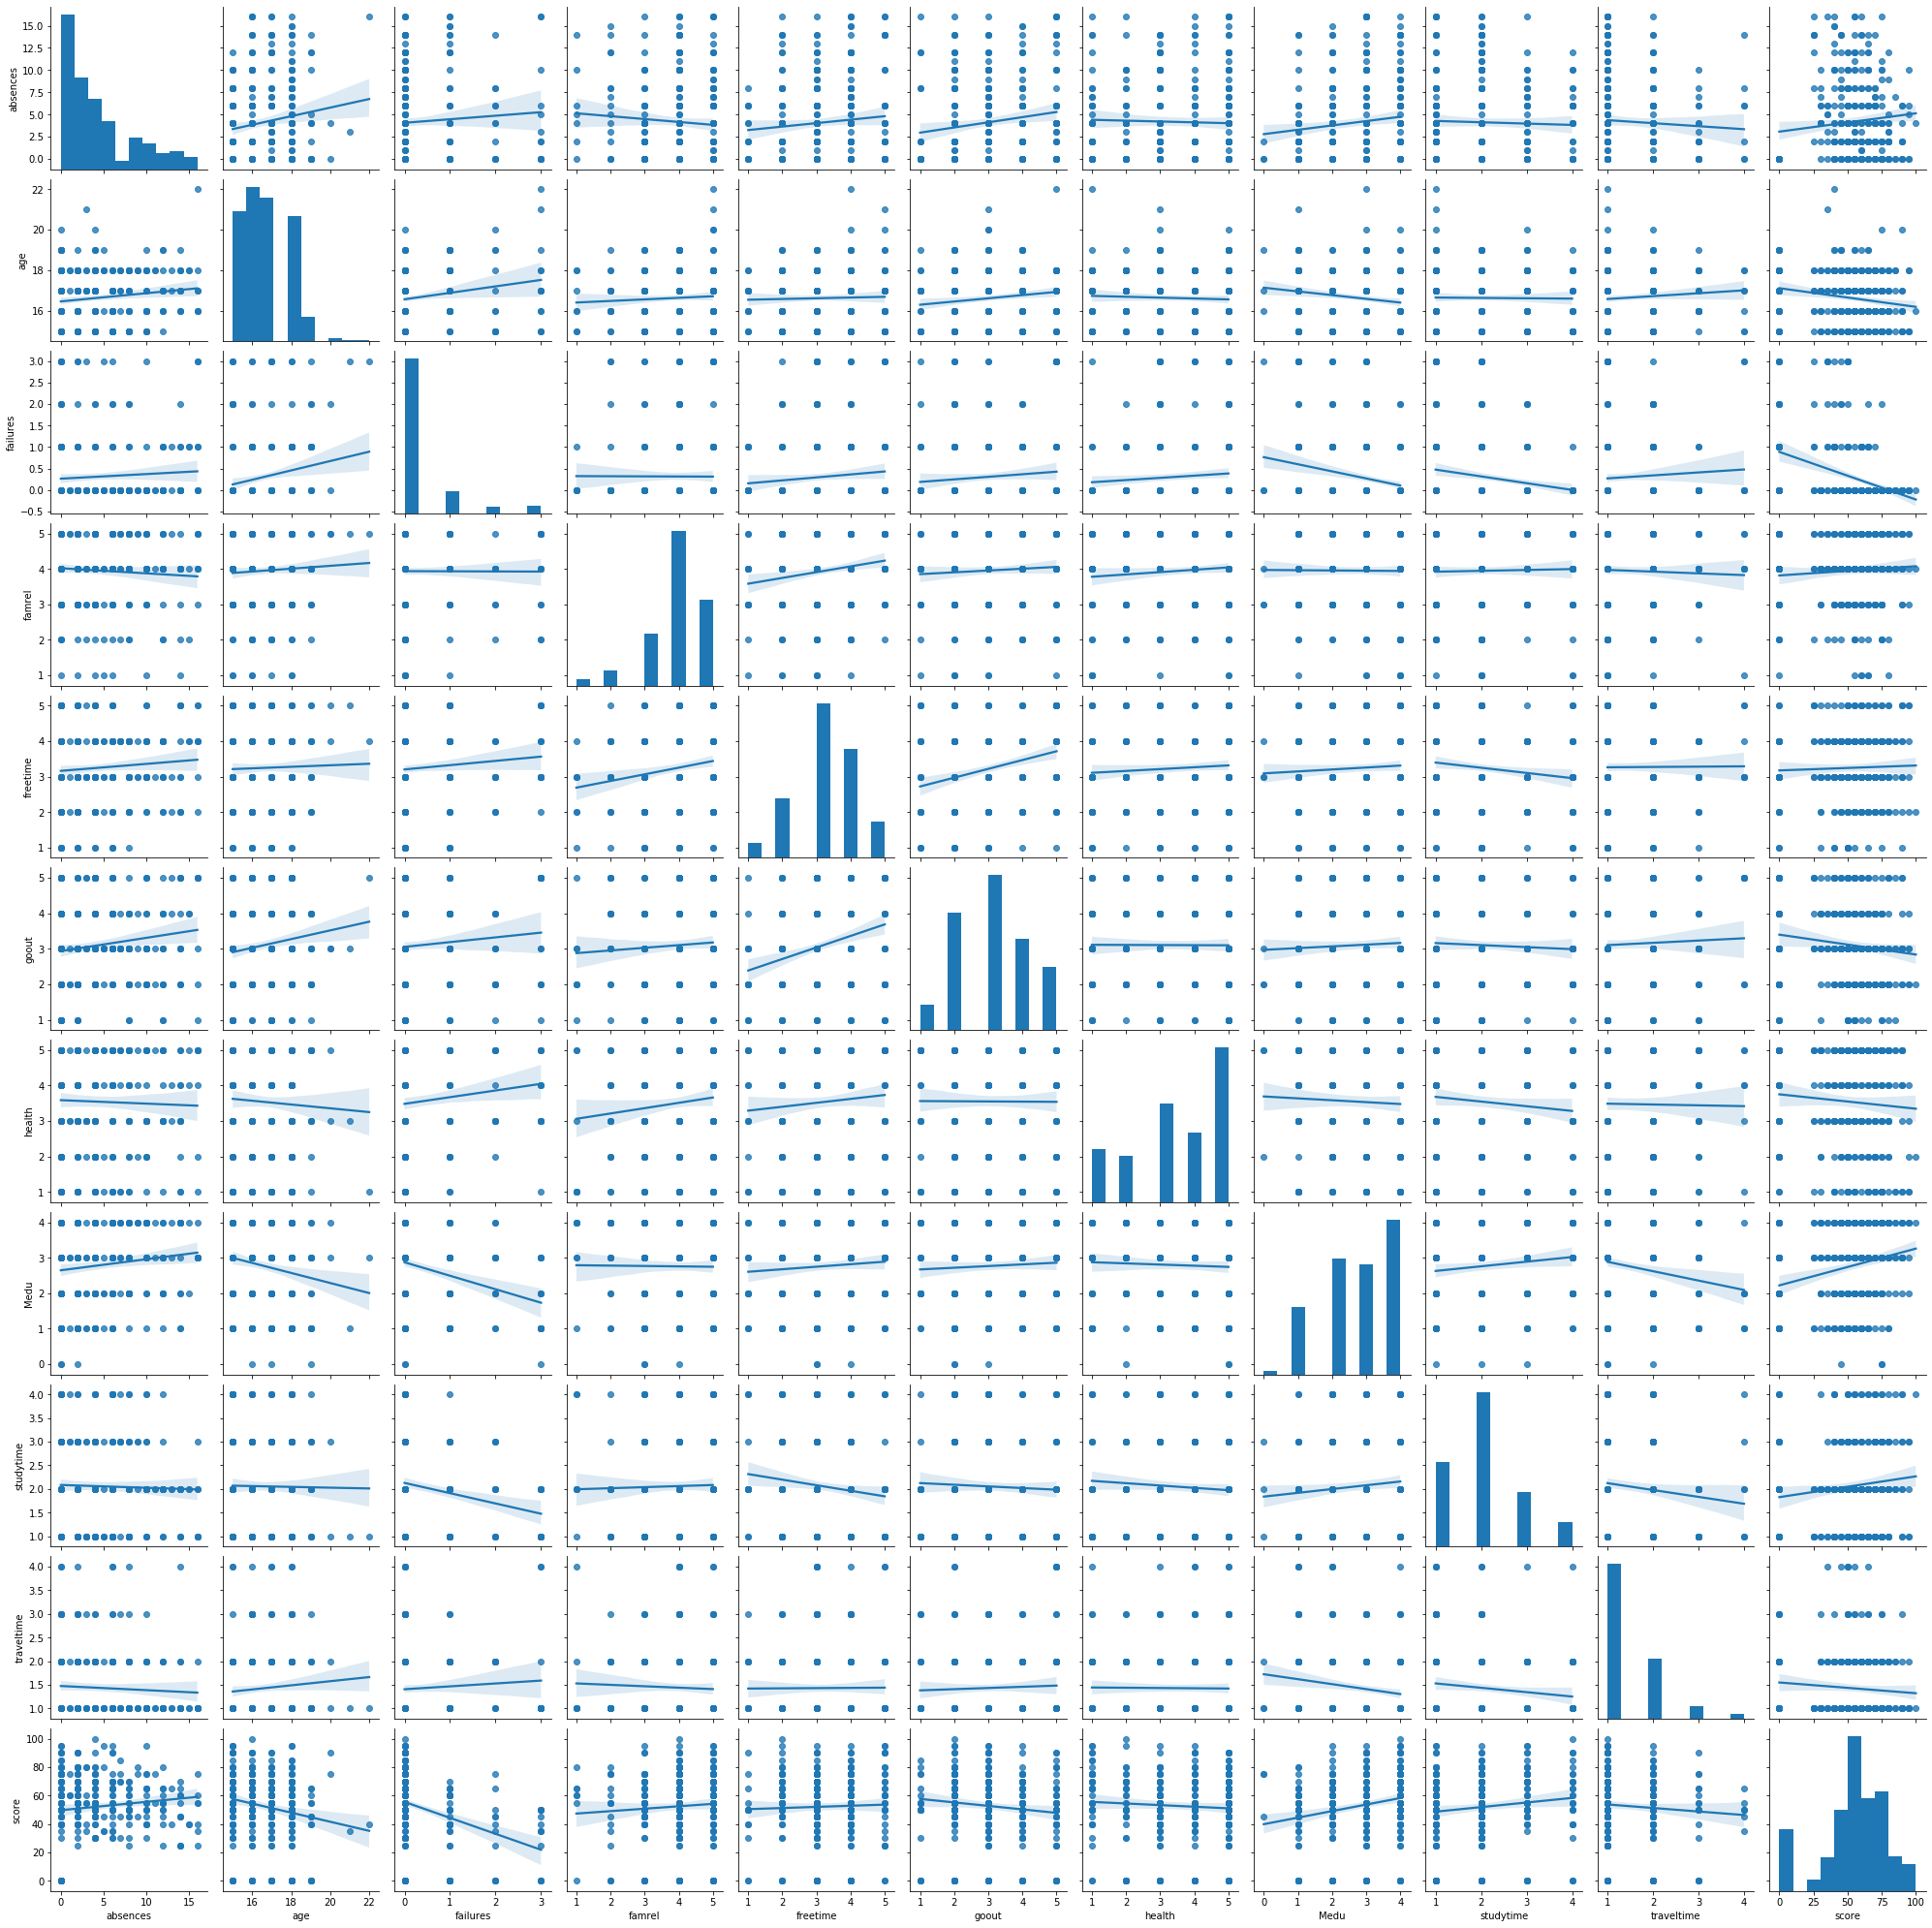

In [51]:
sns.pairplot(studs_model, kind = 'reg') #, vars = ['age', 'absences', 'score'])

In [52]:
studs_model.corr()

,absences,age,failures,famrel,freetime,goout,health,Medu,studytime,traveltime,score
absences,1.000000,0.139740,0.065351,-0.068348,0.087520,0.147428,-0.030557,0.123353,-0.029761,-0.054554,0.110058
age,0.139740,1.000000,0.186248,0.055733,0.027746,0.139188,-0.048087,-0.161016,-0.012158,0.078751,-0.171746
failures,0.065351,0.186248,1.000000,-0.003508,0.091166,0.089345,0.098022,-0.250410,-0.185041,0.064941,-0.352924
famrel,-0.068348,0.055733,-0.003508,1.000000,0.174717,0.061751,0.099257,-0.008737,0.023563,-0.038292,0.066743
freetime,0.087520,0.027746,0.091166,0.174717,1.000000,0.284135,0.075823,0.062450,-0.131239,0.006361,0.033204
goout,0.147428,0.139188,0.089345,0.061751,0.284135,1.000000,-0.004346,0.048024,-0.044747,0.040329,-0.117381
health,-0.030557,-0.048087,0.098022,0.099257,0.075823,-0.004346,1.000000,-0.041884,-0.080740,-0.011341,-0.067845
Medu,0.123353,-0.161016,-0.250410,-0.008737,0.062450,0.048024,-0.041884,1.000000,0.102167,-0.166397,0.218415
studytime,-0.029761,-0.012158,-0.185041,0.023563,-0.131239,-0.044747,-0.080740,0.102167,1.000000,-0.115907,0.119262
traveltime,-0.054554,0.078751,0.064941,-0.038292,0.006361,0.040329,-0.011341,-0.166397,-0.115907,1.000000,-0.075159


## Выводы по датасету

В результате EDA были получены следующие выводы:
* в каждом отдельно взятом столбце мало пропущенных значений. Однако только в 25% строк все данные заполнены
* некорректные значения и выбросы были только в столбцах с данными об образовании отца, семейных отношениях, пропущенных занятиях и оценках.
* вцелом можно сказать, что данные достаточно чистые
* для построения модели предлагается использовать переменные absences, age, failures, famrel, freetime, goout, health, Medu, studytime, traveltime, sex, address, Mjob, schoolsup, paid, higher, romantic
